## Libraries

In [1]:
'''Nath & Data Libraries'''
import numpy as np
from numpy import linspace
import random
import math
import scipy.stats as stats

import netCDF4 as nc4

from scipy.io import loadmat
from scipy import signal
from scipy.stats.kde import gaussian_kde

# import extraction_data as extr # file where the codes used to extract the data are stored

C:\Users\Admin\AppData\Local\Temp\ipykernel_25228\2813075130.py:12: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [15]:
''' ML Libraries'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

# import inverse_model as inver # file where the codes allowing to do the variational inversion are stored

import bottleneck as bn

from sklearn.metrics import mean_squared_error

import pickle

In [3]:
'''Visualization Libraries'''
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import seaborn as sns

## Variables

### Extraction Data

In [4]:
model_dict = dict()
model_dict["IPSL"] = {'hist-GHG' : 10,'hist-aer' : 10, 'hist-nat' : 10,'historical' : 32}
model_dict["ACCESS"] = {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 30}
model_dict["CESM2"] = {'hist-GHG' : 3,'hist-aer' : 2, 'hist-nat' : 3,'historical' : 11}
model_dict["BCC"] = {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 3}
model_dict["CanESM5"] = {'hist-GHG' : 50,'hist-aer' : 30, 'hist-nat' : 50,'historical' : 65}
model_dict["FGOALS"] = {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 6}
model_dict["HadGEM3"] = {'hist-GHG' : 4,'hist-aer' : 4, 'hist-nat' : 4,'historical' : 5}
model_dict["MIRO"] = {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 50}
model_dict["ESM2"] = {'hist-GHG' : 5,'hist-aer' : 5, 'hist-nat' : 5,'historical' : 7}
model_dict["NorESM2"] = {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 3}
model_dict["CNRM"] = {'hist-GHG' : 9,'hist-aer' : 10, 'hist-nat' : 10,'historical' : 30}
model_dict["GISS"] = {'hist-GHG' : 10,'hist-aer' : 12, 'hist-nat' : 20,'historical' : 19}

In [5]:
data_dir = '../data_pre_ind_2/' # Location of the data
b, a = signal.butter(20, 1/5,btype='lowpass') # Lowpass used in the filtrage of the data

cluster_map = np.zeros((36,72),dtype=int)  ## Not sure what this is used for
cluster_map[-9:,:] = 1

fn = data_dir+'obs.nc'
f = nc4.Dataset(fn, 'r')
LAT = f.variables['latitude'][:]
data = f.variables['temperature_anomaly'][:] # This is probably not needed

### Main by year article

In [6]:
BATCH_SIZE = 100

liste_models = ['CanESM5', 'CNRM', 'IPSL','ACCESS','BCC','FGOALS','HadGEM3','MIRO','ESM2','NorESM2','CESM2','GISS']
model_true_name = ['CanESM5','CNRM-CM6-1','IPSL-CM6A-LR','ACCESS-ESM1-5',
                   'BCC-CSM2-MR','FGOALS-g3','HadGEM3','MIROC6','ESM2','NorESM2-LM','CESM2','GISS-E2-1-G','ALL']

Loss_test_complete = []
taille= [10]
regul = [-1]
modules_tot = [-1]

## Classes

### Main by year article 

In [7]:
class Net(nn.Module):
    """Base Neural Net class"""
    def __init__(self,size_channel,bias):
        super(Net, self).__init__()
        self.tanh = nn.Tanh()
        self.conv1 = nn.Conv1d(3,size_channel,kernel_size=11,bias=bias,padding=5)
        self.conv2 = nn.Conv1d(size_channel, size_channel, kernel_size=11,bias=bias,padding=5)
        self.conv3 = nn.Conv1d(size_channel, 1, kernel_size=11, bias=bias,padding=5)

    def forward(self, X):
        x = self.conv1(X)
        x = self.tanh(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = x.float()
        x = self.conv3(x)[:,0,:]

        return x
    
class Linear_mod(nn.Module):
    """
    Simple linear model used for comparison
    """
    def __init__(self):
        super(Linear_mod, self).__init__()
        self.linear = nn.Linear(3,1,bias=False)

    def forward(self, X):
        x = self.linear(X.transpose(1,2))
        return x[:,:,0]

class MonDataset(Dataset):
    """
    Data loader used in the CNN model
    """
    def __init__(self, ghg, aer, nat, historical, all=0, type='train'):
        self.ghg = ghg
        self.aer = aer
        self.nat = nat
        self.historical = historical
        self.type=type
        self.all = all

        print(len(self.ghg))
    def __len__(self):
        # We arbitrarily set an iteration to the study of 50000 cases
        return 50000

    def __getitem__(self, item):
        if (self.type == 'train'):
            #we choose at random a model that is not all
            while True:
                model = random.randint(0, len(self.ghg) - 1)
                if model != self.all: break

            #We randomly choose a simulation of each type of the model

            ghg_max = self.ghg[model].shape[0] - 1
            aer_max = self.aer[model].shape[0] - 1
            nat_max = self.nat[model].shape[0] - 1
            hist_max = self.historical[model].shape[0] - 1

            indice_aer = random.randint(0, aer_max)
            indice_ghg = random.randint(0, ghg_max)
            indice_nat = random.randint(0, nat_max)
            indice_hist = random.randint(0, hist_max)

            #We create the inputs and outputs
            X = torch.stack((self.ghg[model][indice_ghg], self.aer[model][indice_aer], self.nat[model][indice_nat])).float()
            Y = self.historical[model][indice_hist].float()

        elif (self.type == 'test'):
            # same operation but taking only the all model
            model = self.all
            if(model==-1):
                model = random.randint(0, len(self.ghg) - 1)

            ghg_max = self.ghg[model].shape[0] - 1
            aer_max = self.aer[model].shape[0] - 1
            nat_max = self.nat[model].shape[0] - 1
            hist_max = self.historical[model].shape[0] - 1

            indice_aer = random.randint(0, aer_max)
            indice_ghg = random.randint(0, ghg_max)
            indice_nat = random.randint(0, nat_max)
            indice_hist = random.randint(0, hist_max)

            X = torch.stack((self.ghg[model][indice_ghg], self.aer[model][indice_aer], self.nat[model][indice_nat])).float()
            Y = self.historical[model][indice_hist].float()

        return X,Y,model
    
class MonDataset_inverse(Dataset):
    """
    Data loader used in the Variational model
    """
    def __init__(self, ghg, aer, nat):
        #ghg, aer, nat, historical = extr.get_data_set(model=model_data)
        self.ghg = ghg
        self.aer = aer
        self.nat = nat

    def __len__(self):
        return 100

    def __getitem__(self, item):

        ghg_max = self.ghg.shape[0] - 1
        aer_max = self.aer.shape[0] - 1
        nat_max = self.nat.shape[0] - 1

        indice_aer = random.randint(0, aer_max)
        indice_ghg = random.randint(0, ghg_max)
        indice_nat = random.randint(0, nat_max)
        X = torch.stack((self.ghg[indice_ghg], self.aer[indice_aer], self.nat[indice_nat])).float()
        return X


## Functions

### Extraction Data

In [35]:
def get_mean(data, cluster=-1):
    """Calculate the spatially weighted mean over the globe.
    Arguments:
        data
        cluster
    Returns:
        t - spatially averaged mean
    """
    data_mean = np.zeros((data.shape[0]))
    div = 0
    if(cluster==-1):
        for j in range(36): #This can potentially be vectorized instead of using for loops
            for k in range(72):
                data_mean += data[:,j,k] * np.cos(np.radians(LAT[j])) 
                div += np.cos(np.radians(LAT[j]))
            data_mean /= div
    else:
        for j in range(36): #This can potentially be vectorized instead of using for loops
            for k in range(72):
                if(cluster_map[j,k]==cluster):
                    data_mean += data[:, j, k] * np.cos(np.radians(LAT[j]))
                    div += np.cos(np.radians(LAT[j]))
            data_mean /= div
    return data_mean

def get_obs(cluster=-1):
    """Get the observations and calculate the mean over the globe.
    Arguments:
        cluster
    Returns:
        spatially averaged mean of observations
    """
    fn = data_dir + 'obs.nc'
    f = nc4.Dataset(fn, 'r')
    data = f.variables['temperature_anomaly'][:]
    return get_mean(data, cluster=cluster)

def get_pre_ind(data_type, model='IPSL',phys=1):
    """Calculate the pre-industrial average between years 1850-1900 of the models
    Arguments:
        data_type: type of single forcing simulation. One of "hist-GHG", "hist-aer", "hist-nat", "historical"
    Returns:
        pre-industrial average of models
    """
    # Since there are special rules for the GISS model it has to be done like this. Think of ways to make it simpler
    if(model=="GISS"):
        if(type=='hist-aer'):
            if(phys==1):
                result = np.zeros((36,72))
                for i in range(model_dict[model][data_type]):
                    if(i!=5 and i!=6 and i!=7 and i!=8 and i!=9):
                        fn = data_dir + model+'_' + data_type + '_' + str(i+1) + '.nc'
                        f = nc4.Dataset(fn, 'r')
                        data = f.variables['tas'][0:50]
                        result += np.mean(data, axis=0)
                result /= 7
                return result
            else:  
                result = np.zeros((36,72))
                for i in range(model_dict[model][data_type]):
                    if (i == 5 or i == 6 or i == 7 or i == 8 or i == 9):
                        fn = data_dir + model+'_' + data_type + '_' + str(i+1) + '.nc'
                        f = nc4.Dataset(fn, 'r')
                        data = f.variables['tas'][0:50]
                        result += np.mean(data, axis=0)
                result /= 5
                return result
        if(type=='historical'):
            if(phys==1):
                result = np.zeros((36,72))
                for i in range(model_dict[model][data_type]):
                    if(i<10):
                        fn = data_dir + model+'_' + data_type + '_' + str(i+1) + '.nc'
                        f = nc4.Dataset(fn, 'r')
                        data = f.variables['tas'][0:50]
                        result += np.mean(data, axis=0)
                result /= 10
                return result
            else:
                result = np.zeros((36,72))
                for i in range(model_dict[model][data_type]):
                    if (i>=10):
                        fn = data_dir + model+'_' + data_type + '_' + str(i+1) + '.nc'
                        f = nc4.Dataset(fn, 'r')
                        data = f.variables['tas'][0:50]
                        result += np.mean(data, axis=0)
                result /= 9 
                return result
        else:
            result = np.zeros((36, 72))
            for i in range(model_dict[model][data_type]):
                if (i == 5 or i == 6 or i == 7 or i == 8 or i == 9):
                    fn = data_dir + model + '_' + data_type + '_' + str(i + 1) + '.nc'
                    f = nc4.Dataset(fn, 'r')
                    data = f.variables['tas'][0:50]
                    result += np.mean(data, axis=0)
            result /= 5
            return result
    else:
        result = np.zeros((36,72))
        for i in range(model_dict[model][data_type]):
            fn = data_dir + model+'_' + data_type + '_' + str(i+1) + '.nc'
            f = nc4.Dataset(fn, 'r')
            data = f.variables['tas'][0:50]
            result += np.mean(data, axis=0)
        result /= model_dict[model][data_type]
        return result
    
def get_simu(data_type, simu, model='IPSL', cluster=-1, filtrage=False):
    """Used to acquire one simulation from which the pre-industrial average is subtracted 
    Arguments:
        data_type: type of single forcing simulation. One of "hist-GHG", "hist-aer", "hist-nat", "historical"
        simu: number of simulation 
        model: name of one of the 12 models
        cluster:
        filtrage: whether to apply a lowpass filter to the data
    Returns:
        one simulation data for one forcing of a climate model
    """
    # Calculate pre-industrial average
    if model=='GISS':
        phys=1
        i=simu
        if(data_type=='hist-aer'):
            if(i == 6 or i == 7 or i == 8 or i == 9 or i == 10):
                phys=2
        elif(data_type=='historical'):
            if(i>10):
                phys=2
        pre_ind = get_pre_ind(data_type, model=model, phys=phys)
    else:
        pre_ind = get_pre_ind(data_type, model=model)

    # Calculate post-industrial 1900-2015 average
    fn = data_dir + model + '_' + data_type + '_' + str(simu) + '.nc'
    f = nc4.Dataset(fn, 'r')
    data = f.variables['tas'][50:]
    
    # Subtract preindustrial average from the post-industrial data
    data = data - pre_ind
    result = get_mean(data, cluster=cluster)
    
    if(filtrage):
        if(data_type=='hist-GHG' or data_type=='hist-aer'):
            #result = bn.move_mean(result, window=5, min_count=1)
            result = signal.filtfilt(b, a, result)
    return result

def get_data_forcage(data_type, model='IPSL', cluster=-1, filtrage=False):
    """Used to acquire all simulations from one forcing type of a climate model 
    Arguments:
        data_type: type of single forcing simulation. One of "hist-GHG", "hist-aer", "hist-nat", "historical"
        model: name of one of the 12 models
        cluster:
        filtrage: whether to apply a lowpass filter to the data
    Returns:
        all simulation data for one forcing of a climate model
    """
    result = np.zeros((model_dict[model][data_type], 115))
    for i in range(model_dict[model][data_type]):
        result[i] = get_simu(data_type, i+1, model, cluster, filtrage=filtrage)[0:115]
    return (result)

def get_data_set(model='IPSL', cluster=-1, normalize=False, filtrage=False):
    """Used to acquire the entire dataset for one climate model 
    Arguments:
        model: name of one of the 12 models or "ALL" if the data is for all models
        cluster:
        normalize: whether to normalize the data by diving with the maximum value
        filtrage: whether to apply a lowpass filter to the data
    Returns:
        all simulation data for all forcings of a climate model
    """
    liste_max = []
    if (model != 'ALL'):
        # aer = get_data_forcage('hist-aer', model=model, cluster=cluster, filtrage=filtrage)[:,0:115]
        # ghg = get_data_forcage('hist-GHG', model=model, cluster=cluster, filtrage=filtrage)[:,0:115]
        # nat = get_data_forcage('hist-nat', model=model, cluster=cluster, filtrage=filtrage)[:,0:115]
        # historical = get_data_forcage('historical', model=model, cluster=cluster, filtrage=filtrage)[:,0:115]
        # max_hist = np.max(np.mean(historical, axis=0))
        # liste_max.append(max_hist)

        aer = torch.tensor(get_data_forcage('hist-aer', model=model, cluster=cluster, filtrage=filtrage)[:,0:115])
        ghg = torch.tensor(get_data_forcage('hist-GHG', model=model, cluster=cluster, filtrage=filtrage)[:,0:115])
        nat = torch.tensor(get_data_forcage('hist-nat', model=model, cluster=cluster, filtrage=filtrage)[:,0:115])
        historical = torch.tensor(get_data_forcage('historical', model=model, cluster=cluster, filtrage=filtrage)[:,0:115])
        # max_hist = np.max(np.mean(historical, axis=0))
        max_hist = torch.max(torch.mean(historical, dim=0))
        liste_max.append(max_hist)

        if(normalize):
            aer = aer /max_hist
            ghg = ghg / max_hist
            nat = nat / max_hist
            historical = historical/ max_hist

    elif (model == 'ALL'):
        liste_models = ['CanESM5', 'CNRM', 'IPSL', 'ACCESS', 'BCC', 'FGOALS', 'HadGEM3', 'MIRO', 'ESM2',
                        'NorESM2','CESM2','GISS']
        aer = []
        ghg = []
        nat = []
        historical = []

        for model_curr in liste_models:
            print(model_curr)
            aer_curr = torch.tensor(get_data_forcage('hist-aer', model=model_curr, cluster=cluster, filtrage=filtrage)[:, 0:115])
            ghg_curr = torch.tensor(get_data_forcage('hist-GHG', model=model_curr, cluster=cluster, filtrage=filtrage)[:, 0:115])
            nat_curr = torch.tensor(get_data_forcage('hist-nat', model=model_curr, cluster=cluster, filtrage=filtrage)[:, 0:115])
            historical_curr = torch.tensor(get_data_forcage('historical', model=model_curr, cluster=cluster, filtrage=filtrage)[:, 0:115])
            max_hist = torch.max(torch.mean(historical_curr, dim=0))
            liste_max.append(max_hist)

            if(normalize):
                aer_curr = aer_curr / max_hist
                ghg_curr = ghg_curr / max_hist
                nat_curr = nat_curr / max_hist
                historical_curr = historical_curr / max_hist

            aer.append(aer_curr)
            ghg.append(ghg_curr)
            nat.append(nat_curr)
            historical.append(historical_curr)

    return ghg, aer, nat, historical, np.array(liste_max)
    
def get_mean_data_set(model='IPSL', normalize=False, cluster=-1, filtrage=False):
    """Used to acquire the mean of entire dataset for one climate model 
    Arguments:
        model: name of one of the 12 models or "ALL" if the data is for all models
        cluster:
        normalize: whether to normalize the data by diving with the maximum value
        filtrage: whether to apply a lowpass filter to the data
    Returns:
        mean of all simulation data for all forcings of a climate model
    """
    if(model!='ALL'):
        aer = np.mean(get_data_forcage('hist-aer', model=model, cluster=cluster, filtrage=filtrage),axis=0)
        ghg = np.mean(get_data_forcage('hist-GHG', model=model, cluster=cluster, filtrage=filtrage),axis=0)
        nat = np.mean(get_data_forcage('hist-nat', model=model, cluster=cluster, filtrage=filtrage),axis=0)
        historical = np.mean(get_data_forcage('historical', model=model, cluster=cluster, filtrage=filtrage),axis=0)

        if(normalize):
            max_hist = np.max(historical)
            aer = aer /max_hist
            ghg = ghg / max_hist
            nat = nat / max_hist
            historical = historical/ max_hist

    elif(model=='ALL'):
        liste_models = ['CanESM5', 'CNRM', 'IPSL', 'ACCESS', 'BCC', 'FGOALS', 'HadGEM3', 'MIRO', 'ESM2',
                        'NorESM2','CESM2','GISS']
        result = []
        historical = []
        for model_curr in liste_models :
            aer_ipsl = np.mean(get_data_forcage('hist-aer',model=model_curr,cluster=cluster,filtrage=filtrage),axis=0)
            ghg_ipsl = np.mean(get_data_forcage('hist-GHG',model=model_curr,cluster=cluster,filtrage=filtrage),axis=0)
            nat_ipsl = np.mean(get_data_forcage('hist-nat',model=model_curr,cluster=cluster,filtrage=filtrage),axis=0)
            historical_ipsl = np.mean(get_data_forcage('historical',model=model_curr,cluster=cluster,filtrage=filtrage),axis=0)

            if (normalize):
                max_hist = np.max(historical_ipsl)
                aer_ipsl = aer_ipsl / max_hist
                ghg_ipsl = ghg_ipsl / max_hist
                nat_ipsl = nat_ipsl / max_hist
                historical_ipsl = historical_ipsl / max_hist

            result_ipsl = np.stack((ghg_ipsl, aer_ipsl, nat_ipsl))
            result.append(result_ipsl)
            historical.append(historical_ipsl)

        result = np.array(result)
        result = np.mean(result,axis=0)

        historical = np.array(historical)
        historical = np.mean(historical,axis=0)

        return torch.tensor(result).unsqueeze(0), historical

    result = np.stack((ghg, aer, nat))
    return torch.tensor(result).unsqueeze(0), historical

def get_std_data_set(model='IPSL', cluster=-1, normalize=False, filtrage=False):
    """Used to acquire the standard deviation of entire dataset for one climate model 
    Arguments:
        model: name of one of the 12 models or "ALL" if the data is for all models
        cluster:
        normalize: whether to normalize the data by diving with the maximum value
        filtrage: whether to apply a lowpass filter to the data
    Returns:
        standard deviation of all simulation data for all forcings of a climate model
    """
    if(model!='ALL'):
        aer = get_data_forcage('hist-aer', model=model, cluster=cluster, filtrage=filtrage)[:,0:115]
        ghg = get_data_forcage('hist-GHG', model=model, cluster=cluster, filtrage=filtrage)[:,0:115]
        nat = get_data_forcage('hist-nat', model=model, cluster=cluster, filtrage=filtrage)[:,0:115]
        historical = get_data_forcage('historical', model=model, cluster=cluster, filtrage=filtrage)[:,0:115]
        if(normalize):
            max_hist = np.max(np.mean(historical,axis=0))
            aer = aer /max_hist
            ghg = ghg / max_hist
            nat = nat / max_hist
            historical = historical/ max_hist

        aer = np.std(aer,axis=0)
        ghg = np.std(ghg,axis=0)
        nat = np.std(nat,axis=0)
        historical = np.std(historical,axis=0)

    elif(model=='ALL'):
        liste_models = ['CanESM5', 'CNRM', 'IPSL', 'ACCESS', 'BCC', 'FGOALS', 'HadGEM3', 'MIRO', 'ESM2',
                        'NorESM2','CESM2','GISS']
        result = []
        historical = []
        for model_curr in liste_models :
            aer_ipsl = get_data_forcage('hist-aer', model=model_curr, cluster=cluster,filtrage=filtrage)[:, 0:115]
            ghg_ipsl = get_data_forcage('hist-GHG', model=model_curr, cluster=cluster,filtrage=filtrage)[:, 0:115]
            nat_ipsl = get_data_forcage('hist-nat', model=model_curr, cluster=cluster,filtrage=filtrage)[:, 0:115]
            historical_ipsl = get_data_forcage('historical', model=model_curr, cluster=cluster,filtrage=filtrage)[:, 0:115]
            if (normalize):
                max_hist = np.max(np.mean(historical_ipsl, axis=0))
                aer_ipsl = aer_ipsl / max_hist
                ghg_ipsl = ghg_ipsl / max_hist
                nat_ipsl = nat_ipsl / max_hist
                historical_ipsl = historical_ipsl / max_hist

            aer_ipsl = np.std(aer_ipsl, axis=0)
            ghg_ipsl = np.std(ghg_ipsl, axis=0)
            nat_ipsl = np.std(nat_ipsl, axis=0)
            historical_ipsl = np.std(historical_ipsl, axis=0)

            result_ipsl = np.stack((ghg_ipsl, aer_ipsl, nat_ipsl))
            result.append(result_ipsl)
            historical.append(historical_ipsl)

        result = np.array(result)
        result = np.mean(result,axis=0)

        historical = np.array(historical)
        historical = np.mean(historical,axis=0)

        return torch.tensor(result).unsqueeze(0), historical

    result = np.stack((ghg, aer, nat))
    return torch.tensor(result).unsqueeze(0), historical

def get_map_compar(year1, year2, model='CNRM'):
    """Used to acquire the difference of the entire globe for two years of the different models  
    Arguments:
        year1: reference year
        year2: year to calculate the difference
        model: name of one of the 12 models
    Visualizes:
        a global map of difference between model results 
    """
    results = []
    types = ['hist-GHG','hist-aer','hist-nat','historical']
    for type in types :
        dic = {'hist-GHG': 9, 'hist-aer': 10, 'hist-nat': 10, 'historical': 30}
        pre_ind = get_pre_ind(type)

        result = np.zeros((36, 72))
        #print(type)
        if (type == 'hist-GHG'):
            for i in range(2):
                
                fn = data_dir + model + '_' + type + '_' + str(i + 1) + '.nc'
                f = nc4.Dataset(fn, 'r')
                data = f.variables['tas'][year1 - 1850:year2 - 1850]
                result += np.mean(data, axis=0)

            for i in range(3, 10, 1):
                fn = data_dir + model + '_' + type + '_' + str(i) + '.nc'
                f = nc4.Dataset(fn, 'r')
                data = f.variables['tas'][year1 - 1850:year2 - 1850]
                result += np.mean(data, axis=0)
        else :
            for i in range(dic[type]):
                fn = data_dir + model+'_'+type+'_'+str(i+1)+'.nc'
                f = nc4.Dataset(fn, 'r')
                data = f.variables['tas'][year1-1850:year2-1850]
                result +=np.mean(data,axis=0)

        result /= dic[type]
        #results.append(result - pre_ind)
        results.append(result)

    results = np.array(results)
    somme = np.sum(results[0:3],axis=0)
    diff = results[3] - somme

    # map_img = mpimg.imread('carte_terre.png')
    plt.figure(figsize=(14, 8))
    hmax = sns.heatmap(np.flipud(diff), alpha=0.5, annot=False, zorder=2, xticklabels=False,
                        yticklabels=False
                        , square=True,cmap='seismic')
    # hmax.imshow(map_img,
    #             aspect=hmax.get_aspect(),
    #             extent=hmax.get_xlim() + hmax.get_ylim(),
    #             zorder=1)

    plt.xticks([12, 24, 36, 48, 60], ['120°W', '60°W', '0°', '60°E', '120°E'])
    plt.yticks([8, 13, 18, 22, 28], ['60°N', '30°N', '0°', '30°S', '60°S'])
    plt.title('Difference entre simulations historiques et sommes des simulations de forcages \n Années '+str(year1)+'-'+str(year2))
    plt.tight_layout()
    plt.savefig('../figures/diff_'+str(year1)+'_'+str(year2)+'_CNRM')
    plt.show()

def plot_mean_simus():
    """Used plot the mean of simulations over time  
    Visualizes:
        a temporal mean of model simulations 
    """
    liste_models = ['CanESM5', 'CNRM', 'GISS', 'IPSL']
    nom_for= ['GHG','AER','Naturel']

    for i in range(2):
        print(i)
        for mod in liste_models:
            data, hist = get_mean_data_set(model=mod)
            #print(hist.shape)
            plt.plot(data[0,i],label =mod)
        plt.title('Simulation '+str(nom_for[i])+ ' moyenne pour les modèles climatiques')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
                   ['1900', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010',
                    '2020'])
        plt.savefig('../figures/simus_moyenne_'+str(nom_for[i]))
        plt.show()


    for mod in liste_models:
        data, hist = get_mean_data_set(model=mod)
        plt.plot(hist,label =mod)
    obs = get_obs()
    plt.plot(obs,label = 'Observations')
    plt.title('Simulation hist moyenne pour les modèles climatiques')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
               ['1900', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000','2010','2020'])
    plt.savefig('../figures/simus_moyenne_hist')
    plt.show()


### Main by year article

In [9]:
# Function creating a tree to store our results
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

# function creating and training the neural networks
# we give as input the data and the learning parameters and return the learned models
def train_model(data,data_test,lr = 0.001,nb_epoch=100,taille=3,regularisation=-1):
    model = Net(taille ,True)
    model_linear = Linear_mod()

    pytorch_total_params = math.fsum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    criterion = nn.MSELoss()
    if (regularisation!=-1):
        optim = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=regularisation)
        criterion2 = nn.MSELoss()
        optim2 = torch.optim.Adam(model_linear.parameters(), lr=lr,weight_decay=regularisation)
    else:
        optim = torch.optim.Adam(model.parameters(), lr=lr)
        criterion2 = nn.MSELoss()
        optim2 = torch.optim.Adam(model_linear.parameters(), lr=lr)

    Loss_tab = []
    Loss_test_tab = []
    Loss_tab_lin = []
    Loss_test_tab_lin = []

    for n_iter in range(nb_epoch):
        loss_total = 0
        loss_total_test = 0
        length = 0
        length_test = 0

        loss_total_2 = 0
        loss_total_test_2 = 0
        length_2 = 0
        length_test_2 = 0

        with torch.no_grad():
            for(x_test,y_test,mod) in data_test:
                y_hat_test = model(x_test)
                loss_test = criterion(y_hat_test.float(),y_test.float())
                loss_total_test+=loss_test
                length_test += 1

                y_hat_test_2 = model_linear(x_test)
                loss_test_2 = criterion2(y_hat_test_2.float(),y_test.float())
                loss_total_test_2+=loss_test_2
                length_test_2 += 1

        for(x,y,mod) in data:
            y_hat = model(x)
            loss = criterion(y_hat.float(),y.float())
            loss.backward()
            optim.step()
            loss_total+=loss
            optim.zero_grad()
            length +=1

            y_hat_2 = model_linear(x)
            loss_2 = criterion2(y_hat_2.float(),y.float())
            loss_2.backward()
            optim2.step()
            loss_total_2+=loss_2
            optim2.zero_grad()
            length_2 +=1

        print(f"Itérations {n_iter}: CNN:   loss train {loss_total / length} loss test {loss_total_test / length_test}")
        print(f"Itérations {n_iter}: Linear  loss train {loss_total_2 / length_2} loss test {loss_total_test_2 / length_test_2}")
        Loss_tab.append(loss_total.item()/length)
        Loss_test_tab.append(loss_total_test.item()/length_test)

        Loss_tab_lin.append(loss_total_2.item()/length)
        Loss_test_tab_lin.append(loss_total_test_2.item()/length_test)

    Loss_tab = np.array(Loss_tab)
    Loss_test_tab = np.array(Loss_test_tab)

    Loss_tab_lin = np.array(Loss_tab_lin)
    Loss_test_tab_lin = np.array(Loss_test_tab_lin)

    return model, Loss_tab,Loss_test_tab, model_linear, Loss_tab_lin,Loss_test_tab_lin

def model_inverse(entre, cible, model, alpha=0.005):
    """
    function performing the variational inversion
    """
    criterion = nn.MSELoss()

    X = Variable(entre.clone().detach(),requires_grad=True)
    optimizer = torch.optim.Adam([X],lr=0.0001)

    for i in range(100000):
        current = model(X)
        loss = criterion(current.float(),cible.float()) + 0.01 * criterion(X.float(),entre.float())

        if(i%1000==0):
            print(
                f"Itérations {i}:   loss sortie {criterion(current,cible)} loss entree {criterion(entre,X)}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if(criterion(current,cible)<alpha):
            print(i)
            break

    return X, current

# Pipeline

## Extraction Data

In [78]:
liste_models = ['CanESM5', 'CNRM', 'IPSL', 'ACCESS', 'BCC', 'FGOALS', 'HadGEM3', 'MIRO', 'ESM2',
                        'NorESM2','CESM2','GISS']
for i in range(len(ghg)):
    print(i, liste_models[i], ghg[i].shape, aer[i].shape, nat[i].shape, historical[i].shape)

0 CanESM5 torch.Size([50, 115]) torch.Size([30, 115]) torch.Size([50, 115]) torch.Size([65, 115])
1 CNRM torch.Size([9, 115]) torch.Size([10, 115]) torch.Size([10, 115]) torch.Size([30, 115])
2 IPSL torch.Size([10, 115]) torch.Size([10, 115]) torch.Size([10, 115]) torch.Size([32, 115])
3 ACCESS torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([30, 115])
4 BCC torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115])
5 FGOALS torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([6, 115])
6 HadGEM3 torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([5, 115])
7 MIRO torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([50, 115])
8 ESM2 torch.Size([5, 115]) torch.Size([5, 115]) torch.Size([5, 115]) torch.Size([7, 115])
9 NorESM2 torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115])
10 CESM2 torch.Size([3, 115]) torch.Size([2, 115]) torch.Size([3,

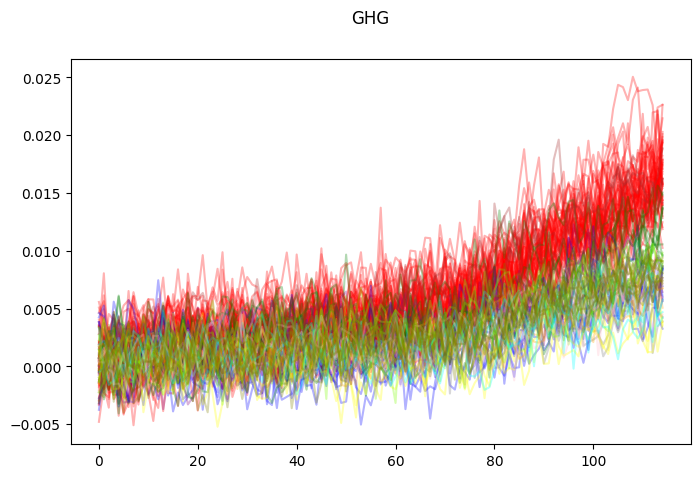

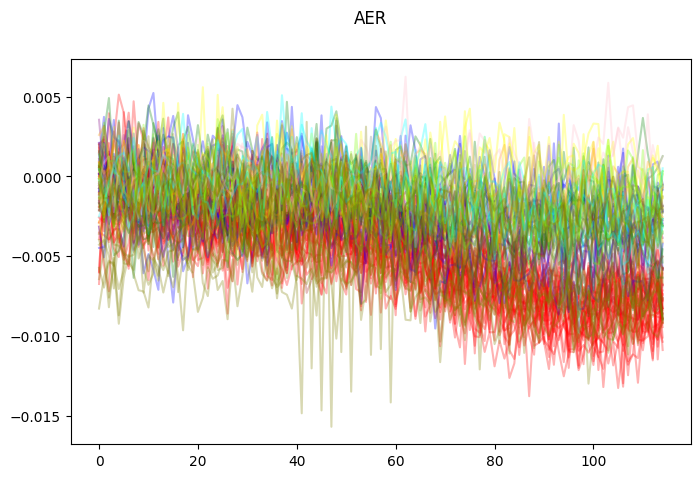

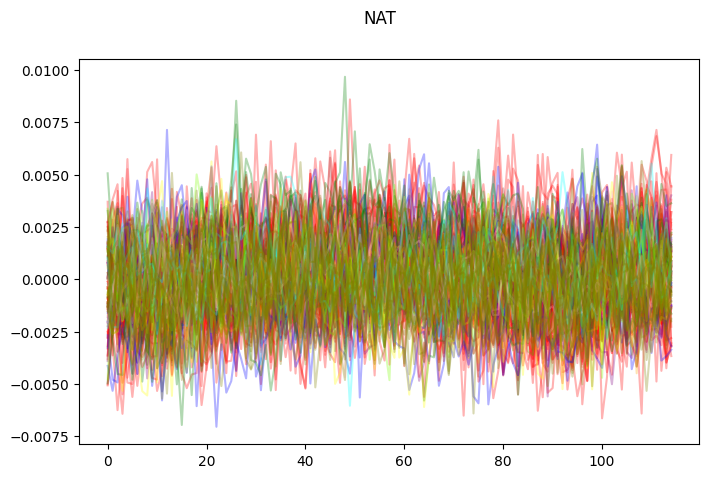

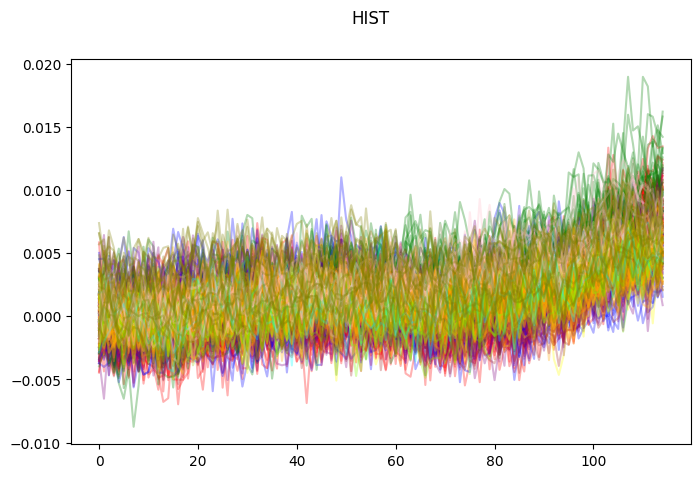

In [101]:
colors_model = ['red','blue','green','purple','gray','yellow','brown','orange','lawngreen','cyan','pink','olive']

for forcing, forcing_name in zip([ghg, aer, nat, historical], ["GHG", "AER", "NAT", "HIST"]):
    fig, ax = plt.subplots(figsize=(8,5))
    plt.suptitle(forcing_name)
    for i in range(len(forcing)):
        for j in range(len(forcing[i])):
            plt.plot(forcing[i][j], color = colors_model[i], alpha = 0.3)
        # break
    plt.show()

In [108]:
# we extract the obs and
obs = torch.tensor(get_obs(cluster=-1))[0:115] * 1.06
max_obs = torch.max(obs)
obs = obs /max_obs

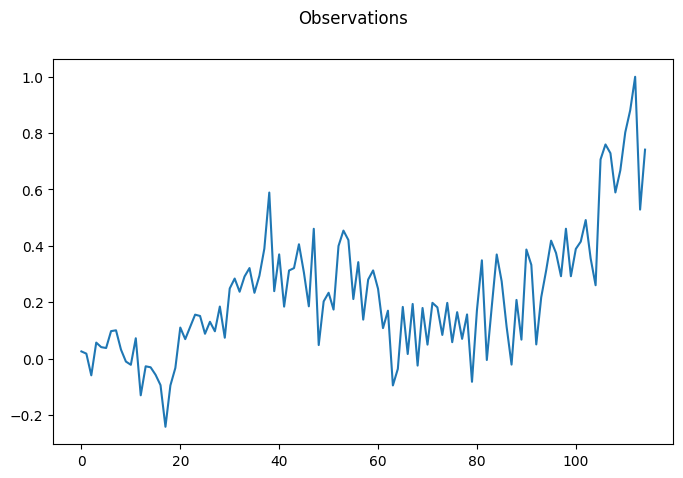

In [109]:
fig, ax = plt.subplots(figsize=(8,5))
plt.suptitle("Observations")
plt.plot(obs)
plt.show()

# Main

In [146]:
data = DataLoader(MonDataset(ghg, aer, nat, historical,type='train',all=1), shuffle=True , batch_size=50)
for d in data:
    print(d)
    print(len(d))
    print(d[0].shape)
    print(d[1].shape)
    print(d[2].shape)
    print(d[2])
    break

[tensor([[[ 7.6441e-04,  1.3730e-03,  2.7182e-03,  ...,  7.0077e-03,
           6.6427e-03,  7.6245e-03],
         [-4.2106e-04, -6.6406e-04, -6.1545e-04,  ..., -3.4781e-03,
          -7.6821e-04, -1.8967e-03],
         [ 7.8064e-04, -1.1780e-04,  9.3012e-04,  ..., -3.9985e-04,
           3.3262e-03,  4.0054e-03]],

        [[ 1.0270e-03,  2.0535e-03,  2.6362e-03,  ...,  1.0505e-02,
           1.0534e-02,  1.0552e-02],
         [ 7.3919e-04, -2.7880e-04,  6.3225e-04,  ..., -3.4714e-03,
          -3.2243e-03, -2.6552e-03],
         [ 1.7596e-03,  8.3147e-04,  3.3623e-03,  ..., -1.9465e-03,
           1.7015e-03, -5.9993e-04]],

        [[-1.3019e-03,  1.7209e-03,  7.5284e-04,  ...,  1.0606e-02,
           8.9357e-03,  8.2128e-03],
         [ 6.8670e-04,  3.3619e-03,  9.4480e-04,  ..., -9.8566e-04,
          -1.6185e-03, -3.2014e-03],
         [ 1.3400e-03,  1.9375e-03,  8.8789e-04,  ...,  2.1657e-03,
          -1.5313e-03,  1.4409e-03]],

        ...,

        [[ 6.4309e-04,  8.0423e-04

In [ ]:
for reg in regul:
    for tai in taille:
        for modu in range(11 ,12):
            nom_dossier_root = '/Result/'
            loss_cur = train_and_plot(nom_dossier_root, all=modu,clus=-1,normalis=True,denormalis=True,taille=tai,filtrage=False,regularisation=reg)
            Loss_test_complete.append(loss_cur)

# Scratch

## Data Acquisition & Processing

In [10]:
clus = -1
liste_models = ['CanESM5', 'CNRM', 'IPSL', 'ACCESS', 'BCC', 'FGOALS', 'HadGEM3', 'MIRO', 'ESM2', 'NorESM2',
                    'CESM2','GISS','ALL']
colors_model = ['red','blue','green','purple','gray','yellow','brown','orange','lawngreen','cyan','pink','olive']

grad='new'
print(clus)

# we extract the obs and
obs = torch.tensor(get_obs(cluster=clus))[0:115] * 1.06
max_obs = torch.max(obs)
obs = obs /max_obs

ghg, aer, nat, historical, liste_max= get_data_set(cluster=clus,model='ALL',normalize=False,filtrage=False)


-1
CanESM5
CNRM
IPSL
ACCESS
BCC
FGOALS
HadGEM3
MIRO
ESM2
NorESM2
CESM2
GISS


## CNN Model

In [11]:
data = DataLoader(MonDataset(ghg, aer, nat, historical,type='train',all=0), shuffle=True , batch_size=BATCH_SIZE)
data_test = DataLoader(MonDataset(ghg, aer, nat, historical,type='test',all=0),shuffle=True, batch_size=BATCH_SIZE)

12
12


In [12]:
for i in range(len(ghg)):
    print(i, liste_models[i], ghg[i].shape, aer[i].shape, nat[i].shape, historical[i].shape)

0 CanESM5 torch.Size([50, 115]) torch.Size([30, 115]) torch.Size([50, 115]) torch.Size([65, 115])
1 CNRM torch.Size([9, 115]) torch.Size([10, 115]) torch.Size([10, 115]) torch.Size([30, 115])
2 IPSL torch.Size([10, 115]) torch.Size([10, 115]) torch.Size([10, 115]) torch.Size([32, 115])
3 ACCESS torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([30, 115])
4 BCC torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115])
5 FGOALS torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([6, 115])
6 HadGEM3 torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([4, 115]) torch.Size([5, 115])
7 MIRO torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([50, 115])
8 ESM2 torch.Size([5, 115]) torch.Size([5, 115]) torch.Size([5, 115]) torch.Size([7, 115])
9 NorESM2 torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115]) torch.Size([3, 115])
10 CESM2 torch.Size([3, 115]) torch.Size([2, 115]) torch.Size([3,

In [13]:
data = DataLoader(MonDataset(ghg, aer, nat, historical,type='train',all=1), shuffle=True , batch_size=50)
for d in data:
    print(d)
    print(len(d))
    print(d[0].shape)
    print(d[1].shape)
    print(d[2].shape)
    print(d[2])
    break

12
[tensor([[[ 7.1337e-04, -5.5725e-04, -1.1352e-04,  ...,  7.6830e-03,
           6.5848e-03,  8.6926e-03],
         [-1.6839e-03, -2.6132e-03, -4.3931e-03,  ..., -3.6729e-03,
          -7.0929e-03, -8.7127e-03],
         [-1.0948e-03, -1.7784e-03, -1.3465e-03,  ...,  2.3941e-04,
          -1.6940e-03, -1.4116e-03]],

        [[-1.2762e-04,  2.3285e-03,  1.7176e-03,  ...,  1.9126e-02,
           1.4868e-02,  1.3012e-02],
         [-5.6436e-04,  7.1258e-04,  9.3902e-04,  ..., -9.4660e-03,
          -9.2943e-03, -8.6126e-03],
         [ 1.5420e-03, -7.3230e-04,  4.3793e-04,  ..., -1.6152e-03,
          -5.5282e-04, -3.9586e-04]],

        [[ 8.2235e-04,  3.9985e-03,  2.3727e-03,  ...,  7.5457e-03,
           7.8528e-03,  5.0702e-03],
         [ 2.5921e-03,  3.1170e-03,  5.9971e-04,  ...,  2.6090e-04,
          -2.1624e-03, -2.5472e-03],
         [ 1.4885e-03,  1.9579e-03, -1.0225e-03,  ..., -4.8480e-04,
          -1.8307e-03,  7.0958e-04]],

        ...,

        [[-5.3887e-04,  2.0358e

In [14]:
model, Loss_tab,Loss_test_tab, model_linear, Loss_tab_lin,Loss_test_tab_lin = train_model(data,data_test,taille=3,regularisation=-1)

238.0
Itérations 0: CNN:   loss train 2.167098682548385e-05 loss test 0.0024596976581960917
Itérations 0: Linear  loss train 7.106743851181818e-06 loss test 1.6366115232813172e-05
Itérations 1: CNN:   loss train 5.869657798029948e-06 loss test 5.455128757603234e-06
Itérations 1: Linear  loss train 6.876905899844132e-06 loss test 6.408060926332837e-06
Itérations 2: CNN:   loss train 5.648039859806886e-06 loss test 5.3998483053874224e-06
Itérations 2: Linear  loss train 6.842963557573967e-06 loss test 6.529216079798061e-06
Itérations 3: CNN:   loss train 5.6222070270450786e-06 loss test 4.948829882778227e-06
Itérations 3: Linear  loss train 6.890956683491822e-06 loss test 6.458446478063706e-06
Itérations 4: CNN:   loss train 5.622619482892333e-06 loss test 4.9997806854662485e-06
Itérations 4: Linear  loss train 6.910097908985335e-06 loss test 6.407876753655728e-06
Itérations 5: CNN:   loss train 5.55440601601731e-06 loss test 5.510754817805719e-06
Itérations 5: Linear  loss train 6.85404

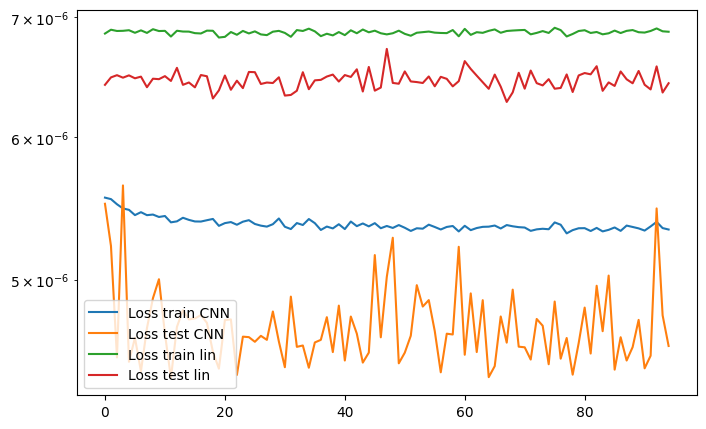

In [16]:
plt.figure(figsize=(8,5))
plt.plot(Loss_tab[5:], label = "Loss train CNN")
plt.plot(Loss_test_tab[5:], label = "Loss test CNN")
plt.plot(Loss_tab_lin[5:], label = "Loss train lin")
plt.plot(Loss_test_tab_lin[5:], label = "Loss test lin")
plt.yscale("log")
plt.legend()
plt.show()

## Inverse Model

In [3]:
def train_inverse_model_all(normalize = False, denormalis = False, cluster = -1, filtrage = False):
    inver_cible=obs
    liste_res_for = []
    liste_res_cible = []

    for i in range(1):#len(liste_models) - 1):

        ghg, aer, nat, hist, liste = get_data_set(liste_models[i], cluster=-1, normalize=normalize,
                                                        filtrage=filtrage)
        # ghg, aer, nat, hist, liste = extr.get_data_set('GISS', cluster=clus, normalis=normalis,
        # filtrage=filtrage)

        data_entree = DataLoader(MonDataset_inverse(ghg, aer, nat),
                                    batch_size=1)
        for pt_depart in data_entree:

            X, current = model_inverse(pt_depart, torch.tensor(inver_cible), model)
            if denormalis:
                # liste_res_for.append(X.clone().detach().numpy()*liste_max[i])
                # liste_res_cible.append(current.clone().detach().numpy()*liste_max[i])
                if (all != -1):
                    liste_res_for.append(X.clone().detach().numpy() * max_obs.item())
                    liste_res_cible.append(current.clone().detach().numpy() * max_obs.item())
                else:
                    liste_res_for.append(X.clone().detach().numpy() * liste_max[all])
                    liste_res_cible.append(current.clone().detach().numpy() * liste_max[all])
            else:
                liste_res_for.append(X.clone().detach().numpy())
                liste_res_cible.append(current.clone().detach().numpy())
    liste_res_for = np.array(liste_res_for)[:, 0]
    liste_res_cible = np.array(liste_res_cible)[:, 0]

    with open('./Results/all_inver.npy', 'wb') as f1:
        np.save(f1, liste_res_for)
        
    return liste_res_for, liste_res_cible

In [5]:
def train_inverse_model_individual(modu = 0, normalize = False, denormalis = False, cluster = -1, filtrage = False):

    inver_cible=obs
    all_tmp = modu

    Result=[]
    ghg_ueless, aer_useless, nat_useless, hist_cible, liste_useless = get_data_set(liste_models[all_tmp],cluster=clus,normalis=False,filtrage=False)

    for numb_inv in range(min(10,hist_cible.shape[0]-1)):
        liste_res_for = []
        liste_res_cible = []
        inver_cible = hist_cible[numb_inv]
        for i in range(len(liste_models)-1):
            if(i!=all_tmp):

                ghg, aer, nat, hist, liste = get_data_set(liste_models[i],cluster=clus,normalis=False, filtrage=False)
                # ghg, aer, nat, hist, liste = extr.get_data_set('GISS', cluster=clus, normalis=normalis,
                                                                # filtrage=filtrage)

                data_entree = DataLoader(MonDataset_inverse(ghg, aer, nat),
                                    batch_size=1)
                for pt_depart in data_entree:

                    X, current = model_inverse(pt_depart,torch.tensor(inver_cible),model)
                    if denormalis:
                        # liste_res_for.append(X.clone().detach().numpy()*liste_max[i])
                        # liste_res_cible.append(current.clone().detach().numpy()*liste_max[i])
                        if (all==-1):
                            liste_res_for.append(X.clone().detach().numpy()*max_obs.item())
                            liste_res_cible.append(current.clone().detach().numpy()*max_obs.item())
                        else:
                            liste_res_for.append(X.clone().detach().numpy()*liste_max[all])
                            liste_res_cible.append(current.clone().detach().numpy()*liste_max[all])

                    else:
                        liste_res_for.append(X.clone().detach().numpy())
                        liste_res_cible.append(current.clone().detach().numpy())
        liste_res_for = np.array(liste_res_for)[:,0]
        liste_res_cible = np.array(liste_res_cible)[:,0]
        #liste_res_for = np.delete(liste_res_for,all,axis=0)
        Result.append(liste_res_for)
    Result = np.array(Result)
    with open('./Model Results/inver_individual_{}.npy'.format(modu), 'wb') as f1:
        np.save(f1,Result)

    return liste_res_for, liste_res_cible

In [ ]:
liste_res_for, liste_res_cible = train_inverse_model_all(normalize = False, denormalis = False, cluster = -1, filtrage = False)

In [ ]:
liste_res_for, liste_res_cible = train_inverse_model_individual(modu = 0, normalize = False, denormalis = False, cluster = -1, filtrage = False)

In [1]:
taille = 10
regul = -1
modules_tot = -1
modu = 11
nom_dossier_root = "/Result/"
clus = -1
normalis = True
denormalis = True
filtrage = False


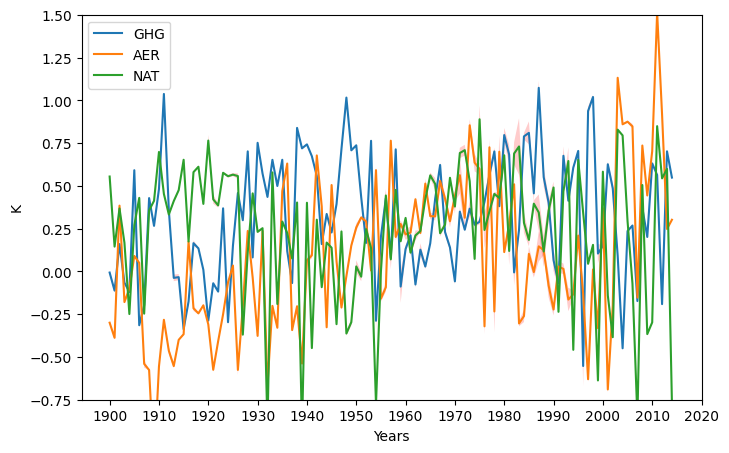

In [60]:
fig, ax = plt.subplots(figsize = (8,5))
forcings = ["GHG", "AER", "NAT"]
for i in range(3):
    mean_res = np.mean(liste_res_for, axis=0)[i] 
    std_res = np.std(liste_res_for, axis=0)[i]
    plt.plot(mean_res, label = forcings[i])
    plt.fill_between(np.arange(115), mean_res - std_res, mean_res + std_res, facecolor='red', alpha=0.2)

plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
            ['1900', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010', '2020'])

plt.ylabel('K')
plt.xlabel('Years')
plt.ylim((-0.75, 1.5))
plt.legend()
plt.show()

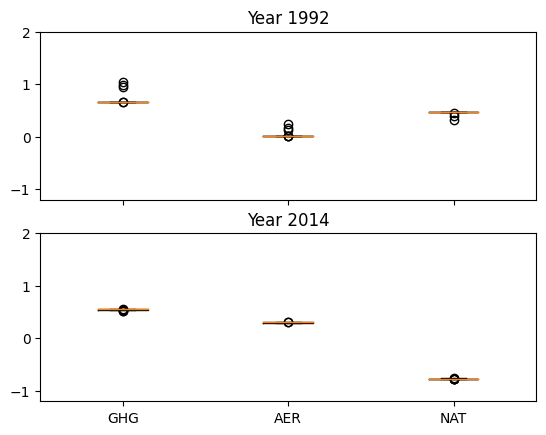

In [61]:
fig, axs = plt.subplots(2,1)

axs[0].boxplot(liste_res_for[:,:,92])

axs[1].boxplot(liste_res_for[:,:,114])
axs[0].set_xticklabels([])
axs[1].set_xticklabels(['GHG','AER','NAT'])

axs[0].set_title('Year 1992')
axs[1].set_title('Year 2014')

axs[0].set_ylim(-1.2,2)
axs[1].set_ylim(-1.2,2)
plt.show()

In [62]:
ALL_data = liste_res_for

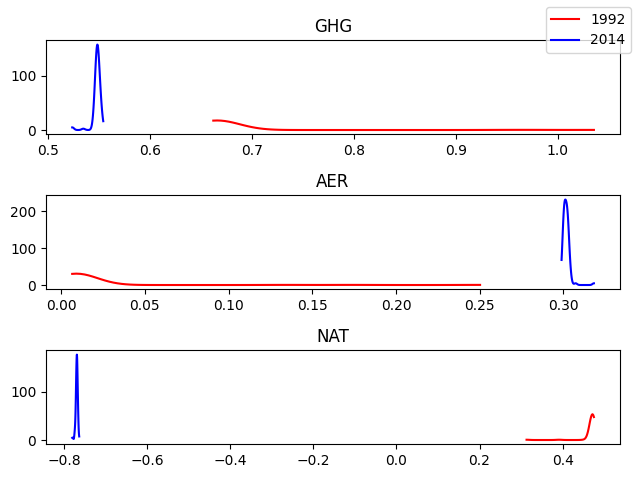

In [63]:
fig, axs = plt.subplots(3,1)

data = ALL_data[:,0,92]
kde = gaussian_kde( data )
dist_space = linspace( min(data), max(data), 100 )

axs[0].plot( dist_space, kde(dist_space),c='red',label='1992')
data = ALL_data[:,0,114]
kde = gaussian_kde( data )
dist_space = linspace( min(data), max(data), 100 )

axs[0].plot( dist_space, kde(dist_space),c='blue',label='2014')
axs[0].set_title('GHG')

data = ALL_data[:,1,92]
kde = gaussian_kde( data )
dist_space = linspace( min(data), max(data), 100 )

axs[1].plot( dist_space, kde(dist_space),c='red')
data = ALL_data[:,1,114]
kde = gaussian_kde( data )
dist_space = linspace( min(data), max(data), 100 )
axs[1].plot( dist_space, kde(dist_space),c='blue')
axs[1].set_title('AER')

data = ALL_data[:,2,92]
kde = gaussian_kde( data )
dist_space = linspace( min(data), max(data), 100 )
axs[2].plot( dist_space, kde(dist_space),c='red')
data = ALL_data[:,2,114]
kde = gaussian_kde( data )
dist_space = linspace( min(data), max(data), 100 )
axs[2].plot( dist_space, kde(dist_space),c='blue')
axs[2].set_title('NAT')

fig.legend()
plt.tight_layout()
plt.show()

In [65]:
moy_ghg = np.mean(ALL_data[:, 0], axis=0)
moy_aer = np.mean(ALL_data[:, 1], axis=0)
moy_nat = np.mean(ALL_data[:, 2], axis=0)

std_ghg = np.std(ALL_data[:, 0], axis=0)
std_aer = np.std(ALL_data[:, 1], axis=0)
std_nat = np.std(ALL_data[:, 2], axis=0)
obs = np.array(get_obs(cluster=-1))[0:115] * 1.06

(100,)
(100,)
(100,)
(100,)
(100,)
(100,)


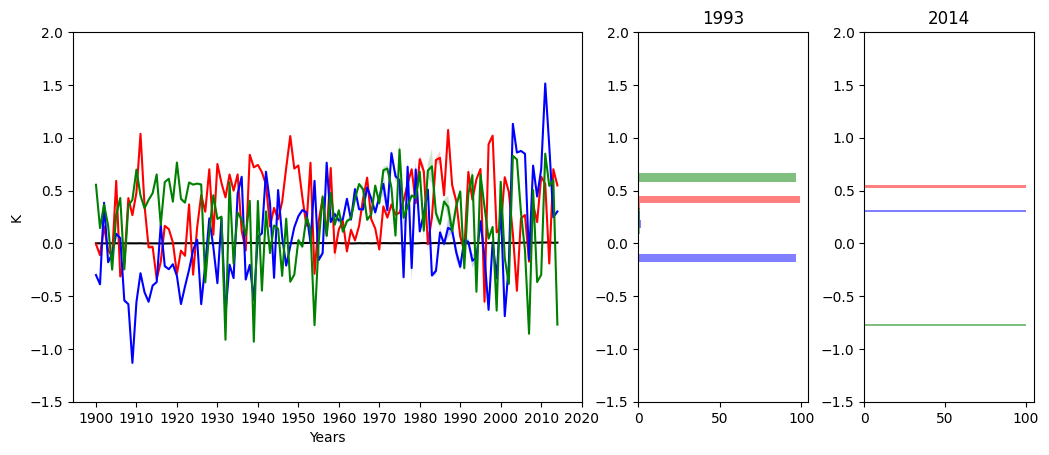

In [66]:
fig, axs = plt.subplots(1,3,figsize=(12.4,4.8),gridspec_kw={'width_ratios': [3,1,1]})

def box_plot(data, edge_color, fill_color):
    bp = axs[1].boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

    return bp

axs[0].plot(np.array(obs), 'black', label="OBS")
axs[0].plot(moy_ghg, 'red', label='GHG')
axs[0].fill_between(np.arange(115), moy_ghg - std_ghg, moy_ghg + std_ghg, facecolor='red', alpha=0.2)
axs[0].plot(moy_aer, 'blue', label='AER')
axs[0].fill_between(np.arange(115), moy_aer - std_aer, moy_aer + std_aer, facecolor='blue', alpha=0.2)
axs[0].plot(moy_nat, 'green', label='NAT')
axs[0].fill_between(np.arange(115), moy_nat - std_nat, moy_nat + std_nat, facecolor='green', alpha=0.2)
axs[0].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
axs[0].set_xticklabels(['1900', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010', '2020'])

axs[0].set_ylabel('K')
axs[0].set_xlabel('Years')

def histo(data,ind,color_model):
    bin = int(round((np.max(data) - np.min(data)) * 10)) +1
    print(data.shape)
    axs[ind].hist(data, bins=bin, stacked=True, color=color_model,alpha=0.5, orientation="horizontal")

histo(ALL_data[:,0,93],1,color_model='red')
histo(ALL_data[:,1,93],1,color_model='blue')
histo(ALL_data[:,2,93],1,color_model='green')
histo(ALL_data[:,0,114],2,color_model='red')
histo(ALL_data[:,1,114],2,color_model='blue')
histo(ALL_data[:,2,114],2,color_model='green')

axs[1].set_title('1993')
axs[2].set_title('2014')

axs[0].set_ylim((-1.5, 2))
axs[1].set_ylim((-1.5, 2))
axs[2].set_ylim((-1.5, 2))

plt.show()

In [34]:
modu = 11

liste_res_for = []
liste_res_cible = []

Result=[]
ghg_ueless, aer_useless, nat_useless, hist_cible, liste_useless = get_data_set(liste_models[modu],cluster=clus,normalis=False,filtrage=False)

for numb_inv in range(min(10,hist_cible.shape[0]-1)):
    liste_res_for = []
    liste_res_cible = []
    inver_cible = hist_cible[numb_inv]
    for i in range(len(liste_models)-1):
        if(i!=modu):

            ghg, aer, nat, hist, liste = get_data_set(liste_models[i],cluster=clus,normalis=False,filtrage=False)
            # ghg, aer, nat, hist, liste = extr.get_data_set('GISS', cluster=clus, normalis=normalis,
                                                            # filtrage=filtrage)

            data_entree = DataLoader(MonDataset_inverse(ghg, aer, nat),
                                batch_size=1)
            for pt_depart in data_entree:

                X, current = model_inverse(pt_depart,torch.tensor(inver_cible),model)
                # if denormalis:
                #     # liste_res_for.append(X.clone().detach().numpy()*liste_max[i])
                #     # liste_res_cible.append(current.clone().detach().numpy()*liste_max[i])
                #     if (all==-1):
                #         liste_res_for.append(X.clone().detach().numpy()*max_obs.item())
                #         liste_res_cible.append(current.clone().detach().numpy()*max_obs.item())
                #     else:
                #         liste_res_for.append(X.clone().detach().numpy()*liste_max[all])
                #         liste_res_cible.append(current.clone().detach().numpy()*liste_max[all])

                # else:
                liste_res_for.append(X.clone().detach().numpy())
                liste_res_cible.append(current.clone().detach().numpy())
    liste_res_for = np.array(liste_res_for)[:,0]
    liste_res_cible = np.array(liste_res_cible)[:,0]
    #liste_res_for = np.delete(liste_res_for,all,axis=0)
    Result.append(liste_res_for)
    
Result = np.array(Result)
with open('./Results/individual_{}_inver.npy'.format(modu), 'wb') as f1:
    np.save(f1,Result)

array([[ 1.97681762e-03,  3.22552925e-03,  2.70502667e-03, ...,
         1.38622089e-02,  1.74618410e-02,  1.95733591e-02],
       [ 6.84908431e-04,  2.67377085e-03, -3.36390013e-04, ...,
         1.69888413e-02,  1.56353876e-02,  1.43767651e-02],
       [ 4.64706816e-03,  5.63913435e-03, -2.00772456e-03, ...,
         1.16374883e-02,  1.60466103e-02,  1.66329356e-02],
       ...,
       [-3.75091617e-04, -2.44294454e-04,  9.32451698e-05, ...,
         1.13235068e-02,  1.70927850e-02,  1.70751711e-02],
       [ 1.08387277e-03,  7.72706750e-04, -6.77508609e-04, ...,
         1.31622422e-02,  1.31194334e-02,  1.57218326e-02],
       [-1.17528797e-03, -1.82894566e-03, -2.63892208e-04, ...,
         1.64566871e-02,  1.59686563e-02,  1.28365661e-02]])

In [7]:
import torch
if torch.cuda.is_available():  # Tell PyTorch to use the GPU. 
    device = torch.device("cuda") 
    print('There are %d GPU(s) available.' % torch.cuda.device_count()) 
    print('We will use the GPU:', torch.cuda.get_device_name(0)) # If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Laptop GPU
